# Basic Image classification task

In [1]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [2]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((64, 64)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [3]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=64,
    transform=transform,
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(363295)


## Model

In [4]:
model = torchvision.models.resnet18(num_classes=200)

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [5]:


trainer = OpenMLTrainerModule(
    experiment_name= "Tiny ImageNet",
    data_module=data_module,
    verbose=True,
    epoch_count=2,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        # TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

train: [5.698934220679012, tensor(0.0040, device='mps:0')]
valid: [5.518991088867187, tensor(0.0056, device='mps:0')]


train: [5.332652150848766, tensor(0.0056, device='mps:0')]
valid: [5.350721232096354, tensor(0.0056, device='mps:0')]
Loss tensor(5.3282, device='mps:0')


train: [5.684366560570988, tensor(0.0068, device='mps:0')]
valid: [5.341361490885417, tensor(0.0056, device='mps:0')]


train: [5.3133089795524695, tensor(0.0062, device='mps:0')]
valid: [5.3085886637369795, tensor(0.0056, device='mps:0')]
Loss tensor(5.3015, device='mps:0')


train: [5.7087848427854935, tensor(0.0059, device='mps:0')]
valid: [5.555184258355035, tensor(0.0056, device='mps:0')]


train: [5.285362413194444, tensor(0.0086, device='mps:0')]
valid: [5.322368028428819, tensor(0.0139, device='mps:0')]
Loss tensor(5.2454, device='mps:0')


train: [5.714453727816358, tensor(0.0040, device='mps:0')]
valid: [5.39200439453125, tensor(0.0028, device='mps:0')]


train: [5.320073784722222, tensor(0.0071, device='mps:0')]
valid: [5.325236341688368, tensor(0.0083, device='mps:0')]
Loss tensor(5.3184, device='mps:0')


train: [5.733638961226852, tensor(0.0062, device='mps:0')]
valid: [5.529576958550347, tensor(0.0083, device='mps:0')]


train: [5.333271243248457, tensor(0.0108, device='mps:0')]
valid: [5.3622755262586805, tensor(0.0111, device='mps:0')]
Loss tensor(5.3805, device='mps:0')


train: [5.712440923996914, tensor(0.0074, device='mps:0')]
valid: [5.361253526475695, tensor(0.0111, device='mps:0')]


train: [5.305141420717592, tensor(0.0086, device='mps:0')]
valid: [5.323407321506076, tensor(0.0111, device='mps:0')]
Loss tensor(5.3132, device='mps:0')


train: [5.716917438271605, tensor(0.0049, device='mps:0')]
valid: [5.728350151909722, tensor(0.0056, device='mps:0')]


train: [5.313776765046296, tensor(0.0077, device='mps:0')]
valid: [5.389488389756944, tensor(0.0056, device='mps:0')]
Loss tensor(5.3266, device='mps:0')


train: [5.729750192901235, tensor(0.0040, device='mps:0')]
valid: [5.5025916205512155, tensor(0.0056, device='mps:0')]


train: [5.3298406153549385, tensor(0.0068, device='mps:0')]
valid: [5.380985514322917, tensor(0.0083, device='mps:0')]
Loss tensor(5.2901, device='mps:0')


train: [5.707011959876543, tensor(0.0074, device='mps:0')]
valid: [5.422740681966146, tensor(0.0056, device='mps:0')]


train: [5.309670380015432, tensor(0.0111, device='mps:0')]
valid: [5.36457994249132, tensor(0.0111, device='mps:0')]
Loss tensor(5.5326, device='mps:0')


train: [5.670561463155864, tensor(0.0071, device='mps:0')]
valid: [5.373425632052951, tensor(0.0111, device='mps:0')]


train: [5.320955102237654, tensor(0.0086, device='mps:0')]
valid: [5.3240478515625, tensor(0.0083, device='mps:0')]
Loss tensor(5.2825, device='mps:0')


## View information about your run

### Learning rate and loss plot

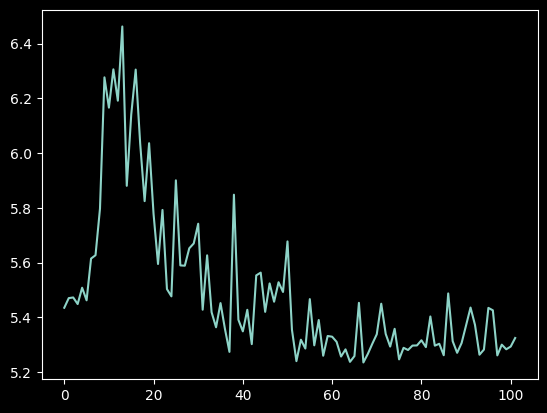

In [6]:
trainer.plot_loss()

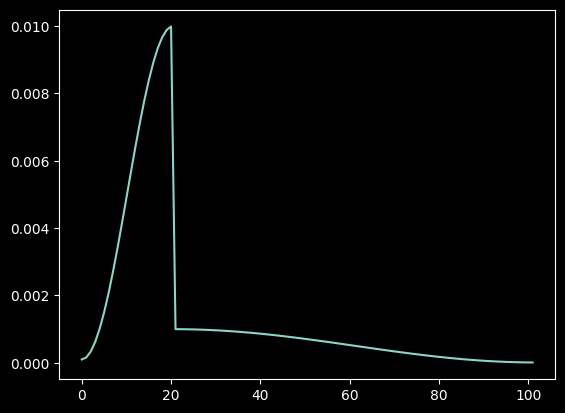

In [7]:
trainer.plot_lr()

In [8]:
trainer.stats.metrics

{'accuracy': [{'train': tensor(0.0071, device='mps:0'),
   'valid': tensor(0.0111, device='mps:0')},
  {'train': tensor(0.0086, device='mps:0'),
   'valid': tensor(0.0083, device='mps:0')}]}

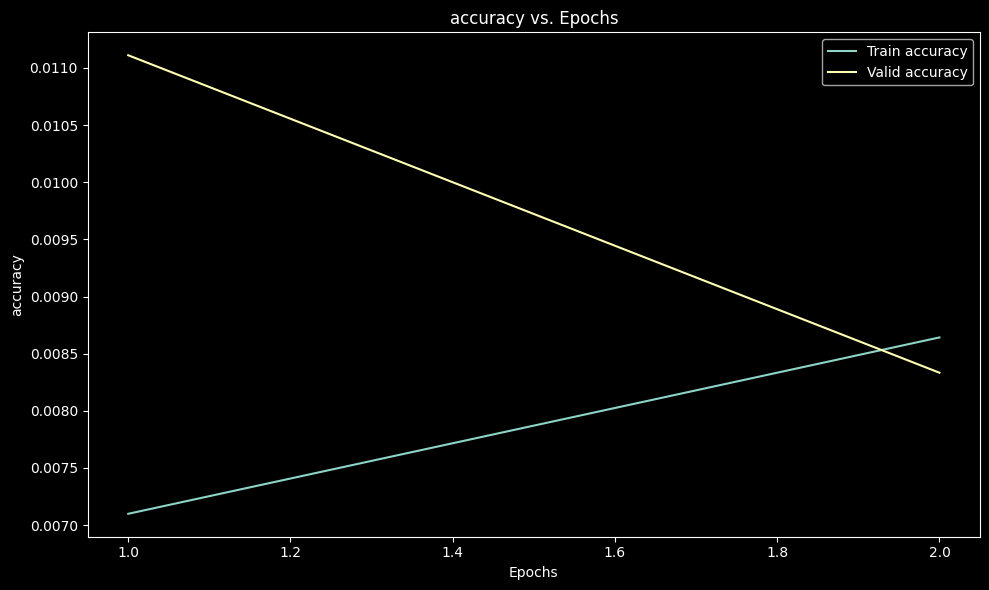

<module 'matplotlib.pyplot' from '/Users/smukherjee/Documents/CODE/Github/OpenML/openml-pytorch/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [9]:
trainer.plot_all_metrics()

### Class labels

In [10]:
trainer.model_classes

array(['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640',
       'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750',
       'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289',
       'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695',
       'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620',
       'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799',
       'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165',
       'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429',
       'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972',
       'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003',
       'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495',
       'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196',
       'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148',
       'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n028

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [11]:
trainer.export_to_netron()

Writing onnx model to model.onnx. Delete if neeeded
Serving 'model.onnx' at http://localhost:8080


### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

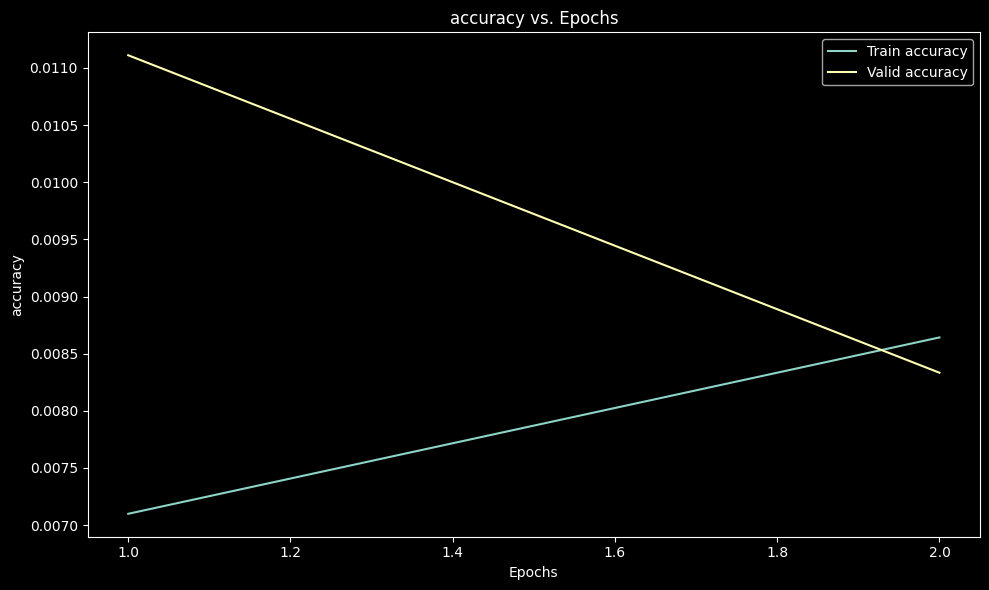

<module 'matplotlib.pyplot' from '/Users/smukherjee/Documents/CODE/Github/OpenML/openml-pytorch/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [12]:
trainer.plot_all_metrics()

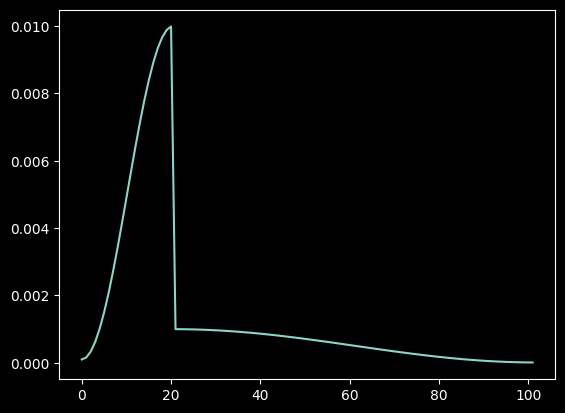

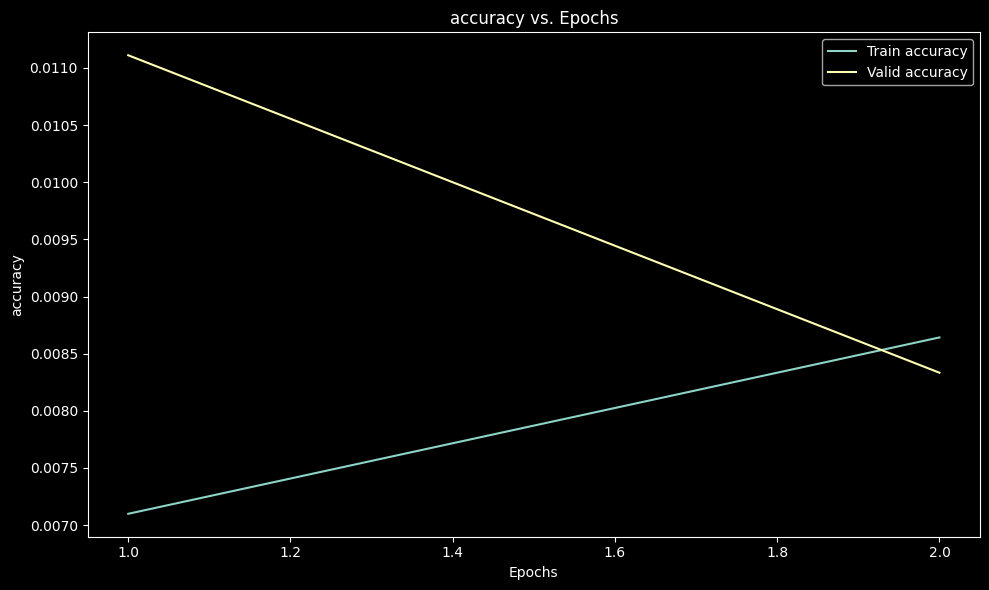

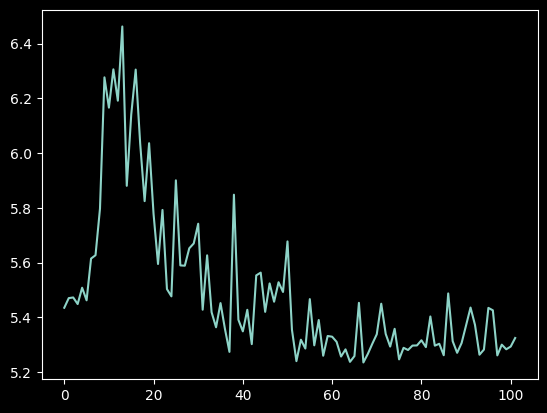

In [13]:
openml.config.apikey = '9cfaf2bb33bd321a7730903a45ea0a45'
run = openml_pytorch.add_experiment_info_to_run(run=run, trainer=trainer) 

In [14]:
run.publish()

OpenML Run
Uploader Name...................: None
Metric..........................: None
Local Result - Accuracy (+- STD): 0.0077 +- 0.0026
Run ID..........................: 10595230
Run URL.........................: https://www.openml.org/r/10595230
Task ID.........................: 363295
Task Type.......................: None
Task URL........................: https://www.openml.org/t/363295
Flow ID.........................: 25942
Flow Name.......................: torch.nn.ResNet.a9c9a0f92fd0c081
Flow URL........................: https://www.openml.org/f/25942
Setup ID........................: None
Setup String....................: Python_3.13.2. Torch_2.6.0. NumPy_2.2.3. SciPy_1.15.2. ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 